In [13]:
import os
import math
import numpy as np
import pandas as pd
import QuantLib as ql
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')
import pandas_market_calendars as mcal
calendar_ = mcal.get_calendar('NASDAQ')

In [29]:
def IR_effect(init_date, start_date, end_date):
    
    beta0 = IRParams.loc[IRParams.Date==init_date, 'BETA0'].item()
    beta1 = IRParams.loc[IRParams.Date==init_date, 'BETA1'].item()
    beta2 = IRParams.loc[IRParams.Date==init_date, 'BETA2'].item()
    tau1 = IRParams.loc[IRParams.Date==init_date, 'TAU1'].item()

    tau = len(calendar_.valid_days(start_date, end_date)) / 252
    r = beta0 + beta1 * (1 - math.exp(-tau/tau1)) / (tau/tau1) + beta2 * ((1 - math.exp(-tau/tau1)) / (tau/tau1) - math.exp(-tau/tau1))
    return r / 100
IRParams = pd.read_csv('interest_rates_parameters.csv', parse_dates=['Date'], dayfirst=True)
IRParams = IRParams.fillna(method = 'ffill')
IRParams.head()

,Date,BETA0,BETA1,BETA2,TAU1
0,2018-01-01,NaN,NaN,NaN,NaN
1,2018-01-02,4.906107,-3.266042,-1.609552,2.342510
2,2018-01-03,4.828470,-3.224984,-1.129529,2.656496
3,2018-01-04,4.699802,-3.106696,-0.773121,2.741904
4,2018-01-05,4.737596,-3.142994,-0.889584,2.618388


In [4]:
def date_Manipulater(t):
    result = pd.to_datetime(t)
    return ql.Date(result.day, result.month, result.year)

def read_all_paths(directory):
    all_paths = []
    for root, dirs, files in os.walk(directory):
        for name in files:
            file_path = os.path.join(root, name)
            all_paths.append(file_path)
        for name in dirs:
            dir_path = os.path.join(root, name)
            all_paths.append(dir_path)
    return all_paths
    
# Define a helper to price options using the Heston model
def model_price(strike, expiry, model):
    payoff = ql.PlainVanillaPayoff(ql.Option.Call, strike)
    exercise = ql.EuropeanExercise(expiry)
    option = ql.VanillaOption(payoff, exercise)
    engine = ql.AnalyticHestonEngine(model)
    if engine is None:
        print("Pricing engine is not initialized properly.")
    option.setPricingEngine(engine)
    return option.NPV()

# Define the objective function (least squares + Tikhonov regularization)
def objective_function(params, market_data, alpha, prior_params):
    v0, kappa, theta, sigma, rho = params
    
    strikes = market_data['strike_prices']
    market_prices = market_data['market_prices']
    expiries = market_data['expiry']
    rf = market_data['risk_free_curve']
    
    heston_process = ql.HestonProcess(ql.YieldTermStructureHandle(rf),
                                      market_data['dividend_yield'],market_data['spot_price'],
                                      v0, kappa, theta, sigma, rho)
    heston_model = ql.HestonModel(heston_process)

    # Calculate the sum of squared errors between model and market prices
    errors = np.sum([(model_price(strike, expiry, heston_model) - market_price)**2
                     for strike, market_price, expiry in zip(strikes, market_prices, expiries)])
    
    # Tikhonov regularization (penalty for deviating from prior guess)
    regularization = alpha * np.sum((params - prior_params)**2)
    
    return errors + regularization


#Calibrate the parameters on each t0
def calibrateHestonT0(df, t0, S0, r0, init_params):
    
    valuation_date = t0
    ql.Settings.instance().evaluationDate = valuation_date
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(S0))
    dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(valuation_date, 0.0, day_count))
    risk_free_curve = ql.FlatForward(valuation_date, ql.QuoteHandle(ql.SimpleQuote(r0)), day_count)
    
    market_data = {
        'strike_prices': df['K'],
        'market_prices': (df['ask']+df['bid'])/2,  # Observed market option prices
        'expiry': df['t'],
        'spot_price': spot_handle,
        'dividend_yield': dividend_yield,
        'risk_free_curve': risk_free_curve
    }
    
    initial_guess = init_params
    prior_params = init_params  # Prior guess for Tikhonov
    alpha = 0.01  # Regularization parameter

    result = minimize(
        objective_function,
        x0=initial_guess,
        args=(market_data, alpha, prior_params),
        method='L-BFGS-B',  # Optimization method, can use other methods
        bounds=[(0.01, 0.2), (0.1, 10), (0.001, 0.2), (0.001, 10.0), (-0.9, 0.9)]  # Bounds on parameters
    )
            
    return result.x

In [16]:
def calc_Payoff(S1,S2):
    return np.maximum(S2 - S1, 0)
def gap_MonteCarlo(T1,T2,params,N,M):
    np.random.seed(42)
    V0, kappa, theta, sigma, rho = params


    # Simulation time settings
    dt = T2 / N  # Time increment
    
    # Correlated random numbers
    W1 = np.random.normal(0, 1, (M, N))
    Z2 = np.random.normal(0, 1, (M, N))
    W2 = rho * W1 + np.sqrt(1 - rho**2) * Z2
    
    # Initialize stock price and variance arrays
    S = np.zeros((M, N + 1))
    V = np.zeros((M, N + 1))
    S[:, 0] = S0
    V[:, 0] = V0
    
    # Simulate paths
    for t in range(1, N + 1):
        # Ensure variance remains positive
        V[:, t] = np.maximum(V[:, t - 1] + kappa * (theta - V[:, t - 1]) * dt + sigma * np.sqrt(V[:, t - 1] * dt) * W2[:, t - 1], 0)
        S[:, t] = S[:, t - 1] * np.exp((r - 0.5 * V[:, t - 1]) * dt + np.sqrt(V[:, t - 1] * dt) * W1[:, t - 1])
    
    # Get values at T1 and T2
    S1 = S[:, int(T1 / dt)]
    S2 = S[:, int(T2 / dt)]
    
    # Calculate payoff and discount it back to present value
    payoff_simu = calc_Payoff(S1, S2)
    
    return np.mean(payoff_simu)

In [6]:
v0 = 0.04          # Initial variance
kappa = 0.8        # Rate of mean reversion
theta = 0.04       # Long-term variance
sigma = 0.1        # Volatility of volatility
rho = -0.2         # Correlation (can be negative)
init_params = np.array([v0, kappa, theta, sigma, rho])

calendar = ql.UnitedStates(ql.UnitedStates.NYSE)
day_count = ql.Actual365Fixed()
N = 100         # Number of time steps
M = 10000 

In [132]:
path

'data/options_call_askbid/.DS_Store'

In [138]:
%%time
directory_path = 'data/options_call_askbid/'  
paths = read_all_paths(directory_path)
# gap_df = pd.DataFrame()
gap_df = pd.read_csv('result_hestonModel.csv',index_col=0)
gap_df.columns = np.array(pd.to_numeric(gap_df.columns).astype('int'))
for path in paths:
    if 'checkpoint' in path:
        continue
    if '.DS_Store' in path:
        continue
    data = pd.read_csv(path,index_col=0)
    pair = path.split('.')[0].split('/')[-1]
    if pair in gap_df.index:
        continue
    print(pair)
    ticker = pair.split('_')[0].lower()
    stock_df = pd.read_csv('data/adjusted_Stock_Daily/{}_stock_daily_adjusted.csv'.format(ticker),index_col=0)
    stock_df = stock_df.set_index('date')

    t0List = data['t0'].unique()
    gap_list = []
    for t0 in t0List:
        df = data[data['t0'] == t0]
    
        df1 = df[['t0','T1','K1','C1_ask','C1_bid']]
        df2 = df[['t0','T2','K2','C2_ask','C2_bid']]
        df1.columns = ['t0','t','K','ask','bid']
        t1 = df1['t'].unique()[0]
        df1['t'] = date_Manipulater(t1)
        df2.columns = ['t0','t','K','ask','bid']
        t2 = df2['t'].unique()[0]
        df2['t'] = date_Manipulater(t2)
        df = pd.concat([df1,df2]).dropna()
    
        S0 = stock_df.loc[t0]['adjusted_price']
        r = IR_effect(t0,t0,t2)
        params = calibrateHestonT0(df,date_Manipulater(t0),S0,r,init_params)
        payoff_Actual = max(stock_df.loc[t2,'adjusted_price']-stock_df.loc[t1,'adjusted_price'],0)

        T1 = day_count.yearFraction(date_Manipulater(t0), date_Manipulater(t1))
        T2 = day_count.yearFraction(date_Manipulater(t0), date_Manipulater(t2))
        gap = (gap_MonteCarlo(T1,T2,params,N,M)-payoff_Actual)/S0
        gap_list.append(gap)
    timeToMaturity = np.busday_count(pd.to_datetime(t0List).values.astype('datetime64[D]'),pd.to_datetime([t1]).values.astype('datetime64[D]'))
    gap_list = pd.DataFrame(gap_list,index=timeToMaturity,columns=[pair]).T
    gap_df = pd.concat([gap_df,gap_list])

TSLA_20210219_20210319
WMT_20210521_20210618
JPM_20221125_20221223
WMT_20190816_20190913
JNJ_20190802_20190830
JNJ_20211112_20211210
PG_20180831_20180928
AMZN_20181102_20181130
JPM_20200529_20200626
MSFT_20210813_20210910
V_20200807_20200904
JPM_20220121_20220218
GOOGL_20201120_20201218
TSLA_20191101_20191129
GOOGL_20190906_20191004
WMT_20191004_20191101
WMT_20221111_20221209
PG_20220729_20220826
AMZN_20200911_20201009
MSFT_20211015_20211112
AMZN_20190104_20190201
GOOGL_20210604_20210702
GOOGL_20200124_20200221
GOOGL_20180202_20180302
JNJ_20200814_20200911
JPM_20211203_20211231
PG_20190104_20190201
PG_20200911_20201009
WMT_20190607_20190705
GOOGL_20210108_20210205
AMZN_20220729_20220826
TSLA_20181228_20190125
JPM_20210806_20210903
TSLA_20180713_20180810
JPM_20181130_20181228
TSLA_20210813_20210910
PG_20180907_20181005
JPM_20180706_20180803
AMZN_20220812_20220909
JPM_20190524_20190621
WMT_20210611_20210709
AMZN_20211210_20220107
V_20220513_20220610
MSFT_20191101_20191129
V_20211001_2021

KeyboardInterrupt: 

In [139]:
gap_df.to_csv('result_hestonModel.csv')

<Axes: >

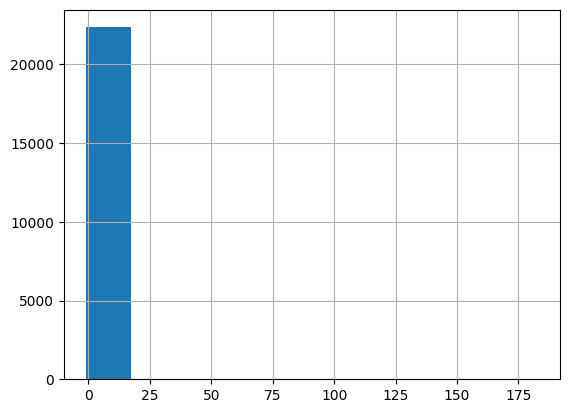

In [140]:
gap_df.stack().hist()

In [141]:
gap_df[gap_df.columns[gap_df.columns>100]].mean()

119   -0.030090
118    0.007371
117    0.070381
116   -0.019908
115   -0.028584
         ...   
178   -0.110442
177   -0.142817
176   -0.114416
175   -0.114528
180   -0.136342
Length: 112, dtype: float64

<Axes: >

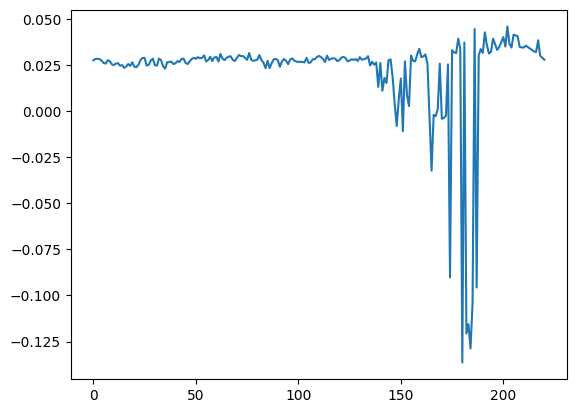

In [142]:
gap_df.median().sort_index().plot()

In [130]:
gap_df.median().sort_index()

0      0.030056
1      0.031697
2      0.032292
3      0.032554
4      0.030545
         ...   
215    0.032343
216    0.032012
217    0.038358
218    0.029967
220    0.027854
Length: 212, dtype: float64

In [107]:
gap_df = pd.read_csv('result_hestonModel.csv',index_col=0)
gap_df.columns = pd.to_numeric(gap_df.columns)
for idx in gap_df.columns:
    if idx+0.1 in gap_df.columns:
        cols = gap_df[idx+0.1].dropna().index
        gap_df.loc[cols,idx] = gap_df.loc[cols,idx+0.1]
        gap_df = gap_df.drop(idx+0.1,axis=1)

In [143]:
gap_df

,15,14,13,12,11,10,9,8,7,6,...,184,183,182,181,179,178,177,176,175,180
AMZN_20191101_20191129,0.018913,0.019293,0.017992,0.017373,0.019779,0.017835,0.017918,0.019288,0.019945,0.020923,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JNJ_20190524_20190621,0.024707,0.027218,0.024971,0.026998,0.027231,0.018578,0.009184,0.026470,0.023622,0.022488,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PG_20180713_20180810,NaN,NaN,NaN,NaN,NaN,NaN,0.004989,NaN,NaN,0.010416,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WMT_20190215_20190315,0.049774,0.050425,0.050836,0.050445,0.050735,0.050099,0.049095,0.049750,0.049869,0.049533,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JNJ_20180706_20180803,NaN,NaN,NaN,NaN,NaN,-0.014310,-0.001190,-0.009687,-0.004433,-0.014843,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WMT_20200724_20200821,NaN,0.038741,0.041830,0.041684,0.041293,0.040586,0.041028,0.041496,0.042461,0.042312,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V_20220708_20220805,NaN,NaN,NaN,NaN,-0.020439,-0.019109,-0.016785,-0.016275,-0.016748,-0.016543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JNJ_20220812_20220909,NaN,NaN,NaN,NaN,0.043162,0.036601,0.039354,0.034119,0.035106,0.035434,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JPM_20191101_20191129,0.005235,-0.002196,0.012168,0.013224,0.014300,0.011568,0.012888,0.014706,0.012191,0.013874,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
